# The Deep Learning Homework 3 - Question No. 04 Part A-5
Bahar Mahdavi - SN: 40152521337

## Load and normalize CIFAR10

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:10<00:00, 15742865.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


## Define a Convolutional Neural Network

In [3]:
import torch.nn as nn
import torch.nn.functional as F

model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

## Define a Loss function and optimizer

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device) # Assuming that we are on a CUDA machine, this should print a CUDA device:

cuda:0


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Summarize the architecture of the model,

In [6]:
from torchsummary import summary

summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
             ReLU-10          [-1, 128, 16, 16]               0
        MaxPool2d-11            [-1, 128, 8, 8]               0
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 256, 8, 8]         295,168
             ReLU-14            [-1, 25

In [7]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
count_parameters(model)

5852234

## Train the network

In [9]:
from tqdm import tqdm

train_losses=[]
train_accu=[]
val_losses=[]
val_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss = 0.0
  correct = 0
  total = 0
  for i, data in enumerate(tqdm(trainloader)):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  train_loss=running_loss/len(trainloader)
  accu = 100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
  
  val_loss, val_acc = validate()
  val_losses.append(val_loss)
  val_accu.append(val_acc)
  print('Val Loss: %.3f | Val Accuracy: %.3f'%(val_loss,val_acc))
  
  if epoch > 1 and val_losses[-1] > val_losses[-2]:
    print('\nValidation loss did not improve, stopping early.')
    return True
  else:
    return False

def validate():
  model.eval()
  
  running_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for data in tqdm(valloader):
      inputs, labels = data[0].to(device), data[1].to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  val_loss = running_loss/len(valloader)
  val_acc = 100.*correct/total
  return val_loss, val_acc

for epoch in range(1, 1000):
  if train(epoch):
    break


Epoch : 1


100%|██████████| 1563/1563 [00:24<00:00, 64.72it/s]


Train Loss: 1.234 | Accuracy: 55.744


100%|██████████| 1563/1563 [00:19<00:00, 78.92it/s]


Val Loss: 0.879 | Val Accuracy: 69.596

Epoch : 2


100%|██████████| 1563/1563 [00:21<00:00, 72.65it/s]


Train Loss: 0.716 | Accuracy: 74.956


100%|██████████| 1563/1563 [00:20<00:00, 77.94it/s]


Val Loss: 0.519 | Val Accuracy: 82.274

Epoch : 3


100%|██████████| 1563/1563 [00:22<00:00, 69.76it/s]


Train Loss: 0.516 | Accuracy: 82.216


100%|██████████| 1563/1563 [00:19<00:00, 81.11it/s]


Val Loss: 0.370 | Val Accuracy: 87.962

Epoch : 4


100%|██████████| 1563/1563 [00:22<00:00, 69.57it/s]


Train Loss: 0.369 | Accuracy: 87.392


100%|██████████| 1563/1563 [00:19<00:00, 79.08it/s]


Val Loss: 0.278 | Val Accuracy: 90.868

Epoch : 5


100%|██████████| 1563/1563 [00:21<00:00, 72.55it/s]


Train Loss: 0.255 | Accuracy: 91.194


100%|██████████| 1563/1563 [00:20<00:00, 78.08it/s]


Val Loss: 0.164 | Val Accuracy: 94.852

Epoch : 6


100%|██████████| 1563/1563 [00:22<00:00, 68.74it/s]


Train Loss: 0.163 | Accuracy: 94.434


100%|██████████| 1563/1563 [00:19<00:00, 80.48it/s]


Val Loss: 0.098 | Val Accuracy: 97.044

Epoch : 7


100%|██████████| 1563/1563 [00:23<00:00, 67.83it/s]


Train Loss: 0.102 | Accuracy: 96.570


100%|██████████| 1563/1563 [00:20<00:00, 77.50it/s]


Val Loss: 0.071 | Val Accuracy: 97.778

Epoch : 8


100%|██████████| 1563/1563 [00:22<00:00, 70.72it/s]


Train Loss: 0.058 | Accuracy: 98.206


100%|██████████| 1563/1563 [00:19<00:00, 78.85it/s]


Val Loss: 0.041 | Val Accuracy: 98.682

Epoch : 9


100%|██████████| 1563/1563 [00:22<00:00, 68.61it/s]


Train Loss: 0.042 | Accuracy: 98.704


100%|██████████| 1563/1563 [00:19<00:00, 78.93it/s]


Val Loss: 0.030 | Val Accuracy: 99.084

Epoch : 10


100%|██████████| 1563/1563 [00:22<00:00, 70.37it/s]


Train Loss: 0.036 | Accuracy: 98.908


100%|██████████| 1563/1563 [00:20<00:00, 77.31it/s]

Val Loss: 0.033 | Val Accuracy: 98.862

Validation loss did not improve, stopping early.


In [10]:
'''from tqdm import tqdm

train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss = 0
  correct = 0
  total = 0

  for data in tqdm(trainloader): 
    
    inputs = data[0].to(device, non_blocking=True)
    labels = data[1].to(device, non_blocking=True)
    
    outputs = model(inputs) # forward
    loss = criterion(outputs, labels)
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward() # backward
    optimizer.step() # optimize

    running_loss += loss.item() # print statistics
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accu = 100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))'''

"from tqdm import tqdm\n\ntrain_losses=[]\ntrain_accu=[]\n\ndef train(epoch):\n  print('\nEpoch : %d'%epoch)\n  \n  model.train()\n\n  running_loss = 0\n  correct = 0\n  total = 0\n\n  for data in tqdm(trainloader): \n    \n    inputs = data[0].to(device, non_blocking=True)\n    labels = data[1].to(device, non_blocking=True)\n    \n    outputs = model(inputs) # forward\n    loss = criterion(outputs, labels)\n    optimizer.zero_grad() # zero the parameter gradients\n    loss.backward() # backward\n    optimizer.step() # optimize\n\n    running_loss += loss.item() # print statistics\n    \n    _, predicted = outputs.max(1)\n    total += labels.size(0)\n    correct += predicted.eq(labels).sum().item()\n      \n  train_loss=running_loss/len(trainloader)\n  accu = 100.*correct/total\n  \n  train_accu.append(accu)\n  train_losses.append(train_loss)\n  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))"

## Test the network on the test data

In [11]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels = data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)
      
      outputs = model(images)

      loss = criterion(outputs, labels)
      running_loss += loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss = running_loss/len(testloader)
  accu = 100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [12]:
epochs = 50
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 1563/1563 [00:22<00:00, 68.19it/s]


Train Loss: 0.026 | Accuracy: 99.190


100%|██████████| 1563/1563 [00:19<00:00, 80.19it/s]


Val Loss: 0.015 | Val Accuracy: 99.576


100%|██████████| 313/313 [00:04<00:00, 70.01it/s]


Test Loss: 0.831 | Accuracy: 82.280

Epoch : 2


100%|██████████| 1563/1563 [00:21<00:00, 71.83it/s]


Train Loss: 0.020 | Accuracy: 99.384


100%|██████████| 1563/1563 [00:20<00:00, 77.72it/s]


Val Loss: 0.010 | Val Accuracy: 99.772


100%|██████████| 313/313 [00:03<00:00, 92.35it/s]


Test Loss: 0.827 | Accuracy: 82.520

Epoch : 3


100%|██████████| 1563/1563 [00:22<00:00, 69.12it/s]


Train Loss: 0.016 | Accuracy: 99.506


100%|██████████| 1563/1563 [00:20<00:00, 77.74it/s]


Val Loss: 0.011 | Val Accuracy: 99.738

Validation loss did not improve, stopping early.


100%|██████████| 313/313 [00:03<00:00, 89.69it/s]


Test Loss: 0.840 | Accuracy: 82.440

Epoch : 4


100%|██████████| 1563/1563 [00:22<00:00, 68.77it/s]


Train Loss: 0.012 | Accuracy: 99.694


100%|██████████| 1563/1563 [00:19<00:00, 80.48it/s]


Val Loss: 0.003 | Val Accuracy: 99.952


100%|██████████| 313/313 [00:04<00:00, 76.87it/s]


Test Loss: 0.820 | Accuracy: 83.370

Epoch : 5


100%|██████████| 1563/1563 [00:22<00:00, 70.91it/s]


Train Loss: 0.005 | Accuracy: 99.882


100%|██████████| 1563/1563 [00:20<00:00, 77.51it/s]


Val Loss: 0.001 | Val Accuracy: 99.992


100%|██████████| 313/313 [00:03<00:00, 90.11it/s]


Test Loss: 0.844 | Accuracy: 83.100

Epoch : 6


100%|██████████| 1563/1563 [00:22<00:00, 68.42it/s]


Train Loss: 0.002 | Accuracy: 99.986


100%|██████████| 1563/1563 [00:20<00:00, 75.68it/s]


Val Loss: 0.001 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 87.94it/s]


Test Loss: 0.842 | Accuracy: 83.600

Epoch : 7


100%|██████████| 1563/1563 [00:23<00:00, 66.79it/s]


Train Loss: 0.001 | Accuracy: 99.998


100%|██████████| 1563/1563 [00:19<00:00, 80.32it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 69.06it/s]


Test Loss: 0.839 | Accuracy: 83.770

Epoch : 8


100%|██████████| 1563/1563 [00:21<00:00, 72.21it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 77.26it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 89.61it/s]


Test Loss: 0.845 | Accuracy: 83.690

Epoch : 9


100%|██████████| 1563/1563 [00:23<00:00, 67.59it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 78.24it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 89.50it/s]


Test Loss: 0.853 | Accuracy: 83.810

Epoch : 10


100%|██████████| 1563/1563 [00:22<00:00, 68.46it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 79.90it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 68.85it/s]


Test Loss: 0.856 | Accuracy: 83.840

Epoch : 11


100%|██████████| 1563/1563 [00:21<00:00, 71.44it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 75.94it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 86.93it/s]


Test Loss: 0.862 | Accuracy: 83.870

Epoch : 12


100%|██████████| 1563/1563 [00:23<00:00, 65.90it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 74.88it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 86.18it/s]


Test Loss: 0.868 | Accuracy: 83.850

Epoch : 13


100%|██████████| 1563/1563 [00:23<00:00, 66.72it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 76.71it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 88.86it/s]


Test Loss: 0.867 | Accuracy: 83.820

Epoch : 14


100%|██████████| 1563/1563 [00:23<00:00, 67.20it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 79.34it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 67.39it/s]


Test Loss: 0.867 | Accuracy: 83.850

Epoch : 15


100%|██████████| 1563/1563 [00:22<00:00, 69.96it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 76.14it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 88.90it/s]


Test Loss: 0.869 | Accuracy: 83.950

Epoch : 16


100%|██████████| 1563/1563 [00:23<00:00, 67.66it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 77.36it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 92.10it/s]


Test Loss: 0.875 | Accuracy: 83.940

Epoch : 17


100%|██████████| 1563/1563 [00:22<00:00, 68.02it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 79.17it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 68.77it/s]


Test Loss: 0.877 | Accuracy: 84.020

Epoch : 18


100%|██████████| 1563/1563 [00:23<00:00, 66.63it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 78.26it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 77.16it/s]


Test Loss: 0.882 | Accuracy: 83.860

Epoch : 19


100%|██████████| 1563/1563 [00:23<00:00, 67.95it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 77.72it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 85.68it/s]


Test Loss: 0.881 | Accuracy: 83.990

Epoch : 20


100%|██████████| 1563/1563 [00:23<00:00, 66.98it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 77.65it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 90.03it/s]


Test Loss: 0.884 | Accuracy: 84.010

Epoch : 21


100%|██████████| 1563/1563 [00:22<00:00, 69.13it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 80.64it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 69.90it/s]


Test Loss: 0.890 | Accuracy: 84.080

Epoch : 22


100%|██████████| 1563/1563 [00:21<00:00, 72.07it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 77.57it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 89.94it/s]


Test Loss: 0.889 | Accuracy: 84.100

Epoch : 23


100%|██████████| 1563/1563 [00:22<00:00, 69.50it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 78.06it/s]


Val Loss: 0.000 | Val Accuracy: 100.000

Validation loss did not improve, stopping early.


100%|██████████| 313/313 [00:03<00:00, 90.64it/s]


Test Loss: 0.891 | Accuracy: 83.940

Epoch : 24


100%|██████████| 1563/1563 [00:22<00:00, 68.34it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 80.21it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 73.03it/s]


Test Loss: 0.892 | Accuracy: 83.980

Epoch : 25


100%|██████████| 1563/1563 [00:21<00:00, 71.89it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 77.02it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 92.21it/s]


Test Loss: 0.890 | Accuracy: 84.080

Epoch : 26


100%|██████████| 1563/1563 [00:22<00:00, 68.54it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 77.91it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 90.89it/s]


Test Loss: 0.897 | Accuracy: 84.000

Epoch : 27


100%|██████████| 1563/1563 [00:23<00:00, 67.73it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 80.52it/s]


Val Loss: 0.000 | Val Accuracy: 100.000

Validation loss did not improve, stopping early.


100%|██████████| 313/313 [00:04<00:00, 71.04it/s]


Test Loss: 0.900 | Accuracy: 83.980

Epoch : 28


100%|██████████| 1563/1563 [00:21<00:00, 71.13it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 77.80it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 93.87it/s]


Test Loss: 0.902 | Accuracy: 83.990

Epoch : 29


100%|██████████| 1563/1563 [00:22<00:00, 69.19it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 77.16it/s]


Val Loss: 0.000 | Val Accuracy: 100.000

Validation loss did not improve, stopping early.


100%|██████████| 313/313 [00:03<00:00, 90.50it/s]


Test Loss: 0.901 | Accuracy: 84.010

Epoch : 30


100%|██████████| 1563/1563 [00:22<00:00, 69.60it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 81.73it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 85.43it/s]


Test Loss: 0.904 | Accuracy: 83.930

Epoch : 31


100%|██████████| 1563/1563 [00:22<00:00, 69.92it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 78.66it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 92.90it/s]


Test Loss: 0.902 | Accuracy: 84.070

Epoch : 32


100%|██████████| 1563/1563 [00:22<00:00, 68.87it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 79.53it/s]


Val Loss: 0.000 | Val Accuracy: 100.000

Validation loss did not improve, stopping early.


100%|██████████| 313/313 [00:04<00:00, 75.59it/s]


Test Loss: 0.899 | Accuracy: 84.100

Epoch : 33


100%|██████████| 1563/1563 [00:22<00:00, 69.99it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 79.40it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 91.81it/s]


Test Loss: 0.904 | Accuracy: 83.940

Epoch : 34


100%|██████████| 1563/1563 [00:22<00:00, 68.33it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 76.98it/s]


Val Loss: 0.000 | Val Accuracy: 100.000

Validation loss did not improve, stopping early.


100%|██████████| 313/313 [00:03<00:00, 89.86it/s]


Test Loss: 0.902 | Accuracy: 84.070

Epoch : 35


100%|██████████| 1563/1563 [00:23<00:00, 67.76it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 78.72it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 82.10it/s]


Test Loss: 0.907 | Accuracy: 83.870

Epoch : 36


100%|██████████| 1563/1563 [00:23<00:00, 67.61it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 80.03it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 75.53it/s]


Test Loss: 0.915 | Accuracy: 84.020

Epoch : 37


100%|██████████| 1563/1563 [00:22<00:00, 70.60it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 76.78it/s]


Val Loss: 0.000 | Val Accuracy: 100.000

Validation loss did not improve, stopping early.


100%|██████████| 313/313 [00:03<00:00, 89.25it/s]


Test Loss: 0.909 | Accuracy: 84.000

Epoch : 38


100%|██████████| 1563/1563 [00:23<00:00, 67.63it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 76.90it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 90.23it/s]


Test Loss: 0.910 | Accuracy: 84.020

Epoch : 39


100%|██████████| 1563/1563 [00:23<00:00, 66.01it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 79.55it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 68.03it/s]


Test Loss: 0.911 | Accuracy: 84.050

Epoch : 40


100%|██████████| 1563/1563 [00:22<00:00, 70.29it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 76.81it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 89.86it/s]


Test Loss: 0.916 | Accuracy: 83.960

Epoch : 41


100%|██████████| 1563/1563 [00:23<00:00, 67.57it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 77.18it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 90.53it/s]


Test Loss: 0.916 | Accuracy: 83.940

Epoch : 42


100%|██████████| 1563/1563 [00:22<00:00, 68.01it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 79.34it/s]


Val Loss: 0.000 | Val Accuracy: 100.000

Validation loss did not improve, stopping early.


100%|██████████| 313/313 [00:04<00:00, 69.88it/s]


Test Loss: 0.919 | Accuracy: 84.030

Epoch : 43


100%|██████████| 1563/1563 [00:23<00:00, 67.53it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 77.45it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 76.72it/s]


Test Loss: 0.917 | Accuracy: 84.100

Epoch : 44


100%|██████████| 1563/1563 [00:22<00:00, 70.15it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 77.70it/s]


Val Loss: 0.000 | Val Accuracy: 100.000

Validation loss did not improve, stopping early.


100%|██████████| 313/313 [00:03<00:00, 91.75it/s]


Test Loss: 0.917 | Accuracy: 84.000

Epoch : 45


100%|██████████| 1563/1563 [00:22<00:00, 68.49it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 78.13it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 87.38it/s]


Test Loss: 0.921 | Accuracy: 83.950

Epoch : 46


100%|██████████| 1563/1563 [00:22<00:00, 68.55it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 80.32it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 76.08it/s]


Test Loss: 0.922 | Accuracy: 84.250

Epoch : 47


100%|██████████| 1563/1563 [00:22<00:00, 70.15it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 76.81it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 90.85it/s]


Test Loss: 0.924 | Accuracy: 84.100

Epoch : 48


100%|██████████| 1563/1563 [00:23<00:00, 65.63it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 76.70it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 90.44it/s]


Test Loss: 0.924 | Accuracy: 84.130

Epoch : 49


100%|██████████| 1563/1563 [00:22<00:00, 69.15it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:19<00:00, 81.72it/s]


Val Loss: 0.000 | Val Accuracy: 100.000

Validation loss did not improve, stopping early.


100%|██████████| 313/313 [00:04<00:00, 69.85it/s]


Test Loss: 0.925 | Accuracy: 84.110

Epoch : 50


100%|██████████| 1563/1563 [00:22<00:00, 70.72it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 1563/1563 [00:20<00:00, 75.74it/s]


Val Loss: 0.000 | Val Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 89.30it/s]

Test Loss: 0.926 | Accuracy: 83.920


## Drowing plots

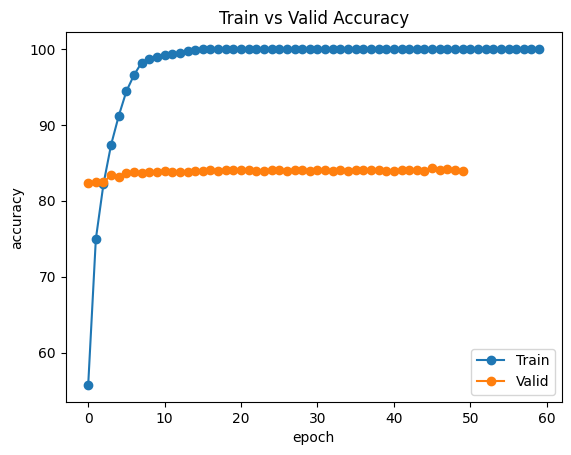

In [13]:
import matplotlib.pyplot as plt

#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

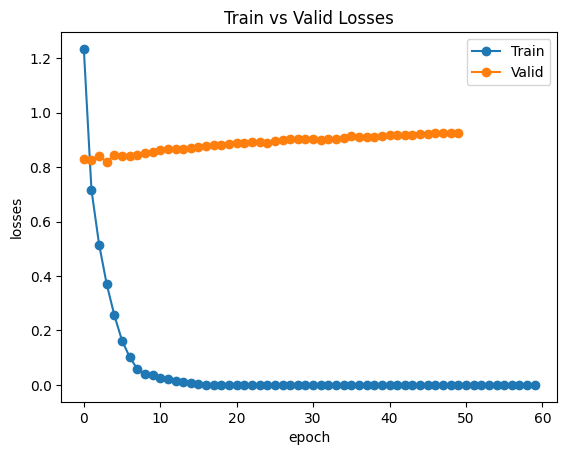

In [14]:
#plot losses
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [15]:
y_true = []
y_pred = []

for data in tqdm(testloader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())

  outputs=model(images)

  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

100%|██████████| 313/313 [00:04<00:00, 67.89it/s]


In [16]:
print(y_pred)
print(y_true)

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 4, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 8, 4, 9, 9, 5, 4, 6, 5, 6, 0, 9, 3, 3, 7, 6, 9, 8, 0, 5, 8, 8, 7, 5, 5, 3, 7, 5, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 9, 2, 0, 3, 3, 8, 8, 1, 1, 7, 2, 7, 2, 8, 8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 7, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 0, 2, 1, 3, 0, 4, 6, 7, 8, 3, 1, 2, 8, 0, 8, 3, 6, 0, 4, 1, 8, 9, 1, 2, 9, 7, 2, 8, 6, 5, 6, 5, 8, 7, 6, 5, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 2, 4, 2, 1, 6, 6, 2, 4, 8, 4, 5, 8, 9, 9, 9, 8, 9, 9, 3, 7, 3, 0, 0, 5, 2, 2, 3, 8, 6, 3, 3, 0, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 5, 0, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2, 7, 5, 9, 7, 3, 9, 6, 4, 3, 2, 5, 1, 5, 8, 8, 0, 4, 9, 5, 5, 1, 1, 8, 9, 0, 6, 1, 8, 2, 2, 5, 3, 9, 9, 2, 0, 3, 0, 0, 9, 8, 1, 5, 5, 0, 8, 8, 4, 7, 0, 2, 5, 6, 3, 8, 5, 0, 2, 4, 7, 9, 1, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 0, 6, 6, 6, 2, 2, 6, 1, 8, 2, 1, 4, 8, 6, 0, 5, 4, 0, 7, 7, 5, 5, 3, 3, 2, 2, 7, 1, 7, 5, 4, 6, 1, 9, 2, 

In [17]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

In [18]:
import pandas as pd

class_names = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names) # Create pandas dataframe

In [19]:
dataframe

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,863,7,27,12,10,6,11,5,35,24
automobile,9,920,1,5,2,2,5,2,17,37
bird,44,0,765,36,58,27,40,19,8,3
cat,16,3,52,672,40,128,50,20,11,8
deer,12,2,37,31,833,23,31,24,7,0
dog,7,1,35,115,35,766,10,26,2,3
frog,5,2,30,44,18,15,881,2,2,1
horse,7,1,18,24,33,30,2,878,3,4
ship,32,14,5,4,3,2,4,3,918,15
truck,22,46,2,9,3,1,4,4,13,896


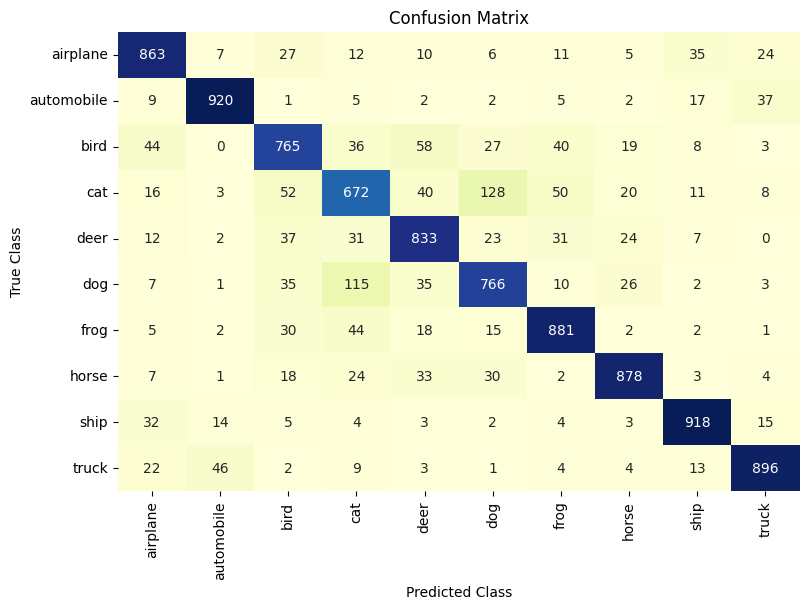

In [20]:
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d") # Create heatmap

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()